In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from glob import glob
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstoneMain/distraction dataset/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
df.shape

(22424, 3)

In [ ]:
# Groupby subjects
by_drivers = df.groupby('subject')
#Group unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id

print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(df.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [ ]:
num_classes = 10

In [ ]:
#Read with opencv
def get_image(path, img_rows, img_cols, color_type=3):

    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

#Loading training dataset
def train_data_load(img_rows=150, img_cols=150, color_type=3):
    train_images=[]
    train_labels=[]

#Loop over the training folder
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes))
        files = glob(os.path.join('/content/drive/MyDrive/capstoneMain/distraction/train/c' + str(classes), '*.jpg'))
#         files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classes), '*.jpg'))
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classes)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = train_data_load(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)

    return x_train, x_test, y_train, y_test


In [ ]:
#Loading validation dataset
def load_test(size=200000, img_rows=150, img_cols=150, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('/content/drive/MyDrive/capstoneMain/distraction/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id


In [ ]:
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [ ]:
pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
img_rows = 150
img_cols = 150
color_type = 3
nb_test_samples = 200

#Loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

#Loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:23<03:34, 23.80s/it]

Loading directory c1


 20%|██        | 2/10 [00:52<03:35, 26.97s/it]

Loading directory c2


 30%|███       | 3/10 [01:22<03:18, 28.35s/it]

Loading directory c3


 40%|████      | 4/10 [01:52<02:52, 28.73s/it]

Loading directory c4


 50%|█████     | 5/10 [02:25<02:31, 30.27s/it]

Loading directory c5


 60%|██████    | 6/10 [03:00<02:07, 31.81s/it]

Loading directory c6


 70%|███████   | 7/10 [03:32<01:35, 31.86s/it]

Loading directory c7


 80%|████████  | 8/10 [04:09<01:06, 33.48s/it]

Loading directory c8


 90%|█████████ | 9/10 [04:34<00:30, 30.86s/it]

Loading directory c9


 11%|█         | 200/1843 [00:10<01:28, 18.59it/s]


In [ ]:
driver_map = {'c0': 'Safe driving',
                'c1': 'Texting - left',
                'c2': 'Talking on the phone - left',
                'c3': 'Texting - right',
                'c4': 'Talking on the phone - right',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

plt.figure(figsize = (12, 20))
image_count = 1

BASE_URL = '/content/drive/MyDrive/capstoneMain/distraction/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(driver_map[directory])


In [ ]:
batch_size = 40
n_epochs = 10

In [ ]:
from keras.layers import Input
inception_v3 = Input(shape = (150,150,3), name = 'Image Input')

## the inception_v3 model
inception_v3_conv = InceptionV3(weights='imagenet', include_top=False, input_tensor = inception_v3)
inception_v3_conv.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image Input (InputLayer)       [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['Image Input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
from keras.models import Model
from keras.optimizers import RMSprop


output_inception_v3_conv = inception_v3_conv(inception_v3)

#Add the fully-connected layers
x = Flatten(name='flatten')(output_inception_v3_conv)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = Dense(10, activation='sigmoid')(x)

inceptionv3_pretrained = Model(inputs = inception_v3, outputs = x)
inceptionv3_pretrained.summary()

#compile the model

inceptionv3_pretrained.compile(optimizer = RMSprop(lr=0.0001),
                               loss = 'binary_crossentropy',
                               metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image Input (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 1024)              18875392  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 40,688,426
Trainable params: 40,653,994
Non-tra

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = inceptionv3_pretrained.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=n_epochs, batch_size=batch_size, verbose=1)
print('History of the training',history.history)

Epoch 1/10
483/483 [==============================] - 103s 170ms/step - loss: 0.0663 - accuracy: 0.8840 - val_loss: 0.0755 - val_accuracy: 0.9706
Epoch 2/10
483/483 [==============================] - 78s 162ms/step - loss: 0.0093 - accuracy: 0.9888 - val_loss: 0.0190 - val_accuracy: 0.9869
Epoch 3/10
483/483 [==============================] - 78s 162ms/step - loss: 0.0071 - accuracy: 0.9927 - val_loss: 0.0613 - val_accuracy: 0.9896
Epoch 4/10
483/483 [==============================] - 78s 162ms/step - loss: 0.0039 - accuracy: 0.9951 - val_loss: 0.0060 - val_accuracy: 0.9946
Epoch 5/10
483/483 [==============================] - 78s 161ms/step - loss: 0.0045 - accuracy: 0.9959 - val_loss: 0.1372 - val_accuracy: 0.9884
Epoch 6/10
483/483 [==============================] - 78s 162ms/step - loss: 0.0028 - accuracy: 0.9969 - val_loss: 0.0115 - val_accuracy: 0.9950
Epoch 7/10
483/483 [==============================] - 78s 162ms/step - loss: 0.0040 - accuracy: 0.9966 - val_loss: 0.0080 - val_a

In [ ]:
inceptionv3_pretrained.save("/content/drive/MyDrive/capstoneMain/inceptionsam_model.h5")

In [ ]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



In [ ]:
def plot_test_class(model, test_files, image_number, color_type=3):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(driver_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

In [ ]:
score1 = inceptionv3_pretrained.evaluate(x_test, y_test, verbose=1)

151/151 [==============================] - 6s 34ms/step - loss: 0.0066 - accuracy: 0.9969


In [ ]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.006592817138880491
Accuracy:  99.68918561935425  %


In [ ]:
for i in range(10,20):
    plot_test_class(inceptionv3_pretrained, test_files, i)

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen  = ImageDataGenerator(rescale = 1.0/255,
                                rotation_range = 40,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                   validation_split = 0.2)

test_gen = ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2 )


In [ ]:
train_generator = train_gen.flow(x_train, y_train, batch_size=batch_size)


validation_generator =  test_gen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
nb_train_samples = 408
nb_validation_samples = 408

history_v2 = inceptionv3_pretrained.fit(train_generator,
                         steps_per_epoch = nb_train_samples,
                         epochs = n_epochs,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_train_samples)

Epoch 1/10
408/408 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.6106

408/408 [==============================] - 128s 253ms/step - loss: 0.1822 - accuracy: 0.6106 - val_loss: 0.0715 - val_accuracy: 0.9018
Epoch 2/10
408/408 [==============================] - 98s 240ms/step - loss: 0.0550 - accuracy: 0.9067
Epoch 3/10
408/408 [==============================] - 96s 235ms/step - loss: 0.0389 - accuracy: 0.9364
Epoch 4/10
408/408 [==============================] - 97s 237ms/step - loss: 0.0319 - accuracy: 0.9517
Epoch 5/10
408/408 [==============================] - 96s 234ms/step - loss: 0.0307 - accuracy: 0.9566
Epoch 6/10
408/408 [==============================] - 97s 238ms/step - loss: 0.0254 - accuracy: 0.9647
Epoch 7/10
408/408 [==============================] - 99s 242ms/step - loss: 0.0227 - accuracy: 0.9675
Epoch 8/10
408/408 [==============================] - 98s 240ms/step - loss: 0.0238 - accuracy: 0.9702
Epoch 9/10
408/408 [==============================] - 97s 238ms/step - loss: 0.0225 - accuracy: 0.9729
Epoch 10/10
408/408 [====================

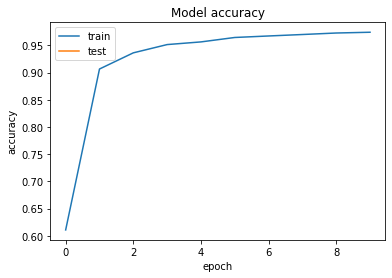

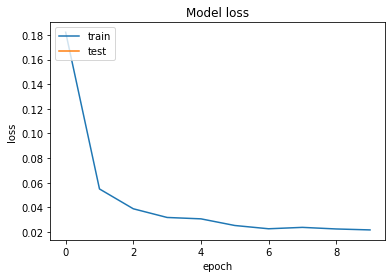

In [ ]:
plot_train_history(history_v2)

In [ ]:
score2 = inceptionv3_pretrained.evaluate_generator(validation_generator, nb_validation_samples // batch_size)

print("Test accuracy for model 1",score1[1])
print("Test accuracy for model 2 (data augmentation):", score2[1])

<ipython-input-28-714185b48235>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score2 = inceptionv3_pretrained.evaluate_generator(validation_generator, nb_validation_samples // batch_size)


NameError: ignored

In [ ]:
inceptionv3_pretrained.save("/content/drive/MyDrive/capstoneMain/inceptionsamaug_model.h5")